# Creating a Simple Strategy

In this tutorial, we will build a [crossover strategy](https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp) that exclusively buys and sells JNUG. It will enter a long position whenever the price goes above its 20-day MA and enter a short position when it goes below.

## Building a Backtest
Use `.BacktesterBuilder`{.interpreted-text role="class"} to configure and create a `.Backtester`{.interpreted-text role="class"} object.

In [1]:
%xmode Minimal

Exception reporting mode: Minimal


In [2]:
from simple_back.backtester import BacktesterBuilder

builder = (
   BacktesterBuilder()
   .name('JNUG 20-Day Crossover')
   .balance(10_000)
   .calendar('NYSE')
   .compare(['JNUG']) # strategies to compare with
   .live_progress() # show a progress bar using tqdm
   .live_plot() # we assume we are running this in a Jupyter Notebook
)

## Running the Backtest
We can now treat the *bt* object like an iterator with a date index.

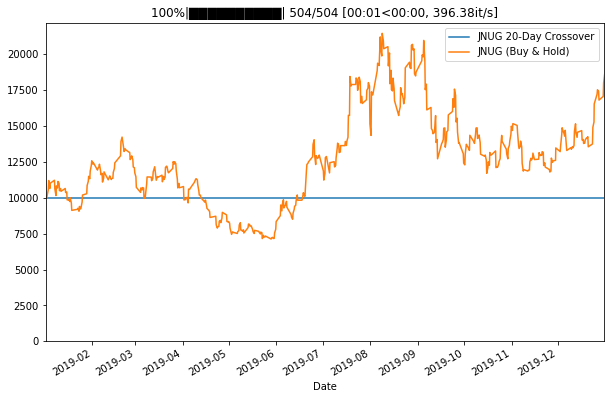

In [3]:
bt = builder.build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    pass
    # code here will be called
    # on 'open' and 'close' events on trading days

Note that we wrote `.compare(['JNUG'])` before so we could compare our strategy to just buying and holding **JNUG**. Because we do not do anything so far, the *JNUG 20-Day Crossover* strategy results in a flat line.

<div class="alert alert-info">

**Note:**

`.BacktesterBuilder.compare`{.interpreted-text role="meth"} normally only accepts a list of `.Strategy`{.interpreted-text role="class"} objects, but for each string that is passed, it automatically creates a `.BuyAndHold`{.interpreted-text role="class"} strategy for the symbol represented by the string.

</div>

## Creating a Strategy
We are now ready to create the strategy. Although not necessary for this strategy, we will only act on market open by checking that `event == 'open'`

We then calculate the 20-day moving average of **JNUGs** close prices.

In [4]:
bt = builder.no_live_plot().build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-20:]['close'].mean()

100%|██████████| 504/504 [00:02<00:00, 233.64it/s]


<div class="alert alert-info">

**Note:**

The second indexer of `b.prices` (implemented in `.DailyPriceProvider`{.interpreted-text role="class"}) can be a date range or single date that allows you to use `int`{.interpreted-text role="class"}, `dateutil.relativedelta.relativedelta`{.interpreted-text role="class"} or `datetime.date`{.interpreted-text role="class"} values.

</div>

We can check if the current price is above or below the moving average using `b.price('JNUG')`.

In [5]:
bt = builder.no_live_plot().build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-20:]['close'].mean()
        if b.price('JNUG') > jnug_ma:
            pass
            # price is above MA
        if b.price('JNUG') < jnug_ma:
            pass
            # price is below MA

100%|██████████| 504/504 [00:01<00:00, 327.48it/s]


Now we should only need to buy when the price is above, and sell when the price is below the MA.

In [6]:
bt = builder.build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-20:]['close'].mean()
        if b.price('JNUG') > jnug_ma:
            b.long('JNUG', percent=1) # as percent of total value
        if b.price('JNUG') < jnug_ma:
            b.short('JNUG', percent=1) # as percent of total value

  1%|          | 3/504 [00:00<00:08, 56.83it/s]


InsufficientCapitalError: 
                        not enough capital available:
                        ordered 1 * 10563.648455632008
                        with only 449.31090733719975 available
                        

But as you might already have expected, this fails with an `.InsufficientCapitalError`{.interpreted-text role="class"} This is because we repeatedly try to invest 100% of our assets into **JNUG**, even when we already hold **JNUG** shares.

<div class="alert alert-info">

**Note:**
    
`.Backtester.long`{.interpreted-text role="meth"} and `.Backtester.short`{.interpreted-text role="meth"} allow for use of the following arguments: **percent**: order as percent of total value; **percent_available**: order as percent of the available cash; **absolute**: order as absolute cash value; **nshares**: order as number of shares.
</div>

To fix the previous error we now check if the corresponding positions are already in our portfolio, and liquidate positions of the wrong kind. We liquidate long positions before we go short and vice versa:

In [7]:
bt = builder.build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-20:]['close'].mean()

        if b.price('JNUG') > jnug_ma:
            if not b.portfolio['JNUG'].long: # check if we already are long JNUG
                b.portfolio['JNUG'].short.liquidate() # liquidate any/all short JNUG positions
                b.long('JNUG', percent=1) # long JNUG

        if b.price('JNUG') < jnug_ma:
            if not b.portfolio['JNUG'].short: # check if we already are short JNUG
                b.portfolio['JNUG'].long.liquidate() # liquidate any/all long JNUG positions
                b.short('JNUG', percent=1) # short JNUG

100%|██████████| 504/504 [00:01<00:00, 350.42it/s]


## Inspecting Metrics
Now that our Backtest is complete, we can use `.Backtester.metrics`{.interpreted-text role="class"} and `.Backtester.summary`{.interpreted-text role="class"} to get more details. Both of these will return DataFrames.

### Metrics

In [8]:
bt.metrics

Max Drawdown  Annual Return  \
Backtest              Date       Event                                
JNUG 20-Day Crossover 2019-01-02 open   -3107.110029       0.525525   
                                 close  -3107.110029       0.525525   
                      2019-01-03 open   -3107.110029       0.525525   
                                 close  -3107.110029       0.525525   
                      2019-01-04 open   -3107.110029       0.525525   
...                                              ...            ...   
JNUG (Buy & Hold)     2019-12-27 close  -3441.210832       1.799052   
                      2019-12-30 open   -3441.210832       1.799052   
                                 close  -3441.210832       1.799052   
                      2019-12-31 open   -3441.210832       1.799052   
                                 close  -3441.210832       1.799052   

                                        Portfolio Value   Total Value  \
Backtest              Date       Event                                  
JNUG 20-Day Crossover 2019-01-02 open          0.000000  10000.000000   
                                 close      9696.819855  10146.130762   
                      2019-01-03 open      10114.337548  10563.648456   
                                 close     10751.050232  11200.361139   
                      2019-01-04 open      10197.839717  10647.150624   
...                                                 ...           ...   
JNUG (Buy & Hold)     2019-12-27 close     16358.200195  16807.511103   
                      2019-12-30 open      16615.727700  17065.038607   
                                 close     17553.713379  18003.024286   
                      2019-12-31 open      18221.607392  18670.918299   
                                 close     17476.245117  17925.556025   

                                        Daily Profit/Loss  
Backtest              Date       Event                     
JNUG 20-Day Crossover 2019-01-02 open            0.000000  
                                 close           0.000000  
                      2019-01-03 open          563.648456  
                                 close        1054.230377  
                      2019-01-04 open           83.502169  
...                                                   ...  
JNUG (Buy & Hold)     2019-12-27 close        -718.145142  
                      2019-12-30 open         -343.369146  
                                 close        1195.513184  
                      2019-12-31 open         1605.879692  
                                 close         -77.468262  

[1008 rows x 5 columns]

### Summary

In [9]:
bt.summary

,Max Drawdown,Annual Return,Portfolio Value (Last Value),Total Value (Last Value),Daily Profit/Loss (Last Value)
Backtest,,,,,
JNUG 20-Day Crossover,-3107.110029,0.525525,4993.212891,5276.118290,-22.133789
JNUG (Buy & Hold),-3441.210832,1.799052,17476.245117,17925.556025,-77.468262


## Strategies
You can also use `.Backtester.strategies`{.interpreted-text role="meth"} which returns a `.StrategySequence`{.interpreted-text role="class"}, with their own `.Backtester.metrics`{.interpreted-text role="obj"} and `.Backtester.summary`{.interpreted-text role="obj"}.

In [10]:
bt.strategies['JNUG 20-Day Crossover'].metrics

Max Drawdown  Annual Return  \
Backtest              Date       Event                                
JNUG 20-Day Crossover 2019-01-02 open   -3107.110029       0.525525   
                                 close  -3107.110029       0.525525   
                      2019-01-03 open   -3107.110029       0.525525   
                                 close  -3107.110029       0.525525   
                      2019-01-04 open   -3107.110029       0.525525   
...                                              ...            ...   
JNUG (Buy & Hold)     2019-12-27 close  -3441.210832       1.799052   
                      2019-12-30 open   -3441.210832       1.799052   
                                 close  -3441.210832       1.799052   
                      2019-12-31 open   -3441.210832       1.799052   
                                 close  -3441.210832       1.799052   

                                        Portfolio Value   Total Value  \
Backtest              Date       Event                                  
JNUG 20-Day Crossover 2019-01-02 open          0.000000  10000.000000   
                                 close      9696.819855  10146.130762   
                      2019-01-03 open      10114.337548  10563.648456   
                                 close     10751.050232  11200.361139   
                      2019-01-04 open      10197.839717  10647.150624   
...                                                 ...           ...   
JNUG (Buy & Hold)     2019-12-27 close     16358.200195  16807.511103   
                      2019-12-30 open      16615.727700  17065.038607   
                                 close     17553.713379  18003.024286   
                      2019-12-31 open      18221.607392  18670.918299   
                                 close     17476.245117  17925.556025   

                                        Daily Profit/Loss  
Backtest              Date       Event                     
JNUG 20-Day Crossover 2019-01-02 open            0.000000  
                                 close           0.000000  
                      2019-01-03 open          563.648456  
                                 close        1054.230377  
                      2019-01-04 open           83.502169  
...                                                   ...  
JNUG (Buy & Hold)     2019-12-27 close        -718.145142  
                      2019-12-30 open         -343.369146  
                                 close        1195.513184  
                      2019-12-31 open         1605.879692  
                                 close         -77.468262  

[1008 rows x 5 columns]

The advantage of using using `.StrategySequence`{.interpreted-text role="class"} is that we can also use it for plotting.

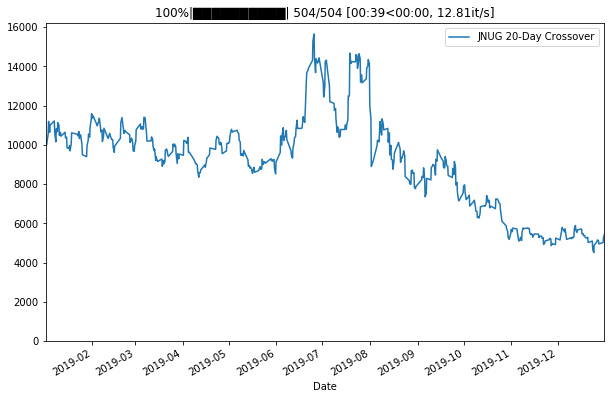

In [11]:
bt.strategies[0].show()